In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open(f'../../loss/ResDepth_montecarlo_v0.pkl', 'rb') as f:
        experiment_data = pickle.load(f)

In [3]:
# define input channels for model
all_input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'snowon_cr',
    'snowoff_cr',
    'delta_cr',
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'ndvi',
    'ndsi',
    'ndwi',
    'fcf',
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tri',
    'tpi',
    'latitude',
    'longitude',
    'dowy']

In [4]:
val_channel_performance = {}
all_values = {}
val_w_stdev_list = []
for channel in all_input_channels:
    val_loss_w_channel = []
    val_loss_wo_channel = []
    for trial in experiment_data.keys():
        if channel in experiment_data[trial][0]:
            val_loss_w_channel.append(experiment_data[trial][1])
        else:
            val_loss_wo_channel.append(experiment_data[trial][1])
    val_loss_diff = np.mean(val_loss_w_channel) - np.mean(val_loss_wo_channel)
    val_w_stdev_list.append(np.std(val_loss_w_channel))
    val_channel_performance[channel] = val_loss_diff
    all_values[channel] = [val_loss_w_channel, val_loss_wo_channel]

df = pd.DataFrame({
    'channels': val_channel_performance.keys(),
    'val_loss_diff': val_channel_performance.values(),
    'val_w_stdev':val_w_stdev_list
})

df_summary = df.sort_values('val_loss_diff', ascending=True)

In [5]:
# Find the maximum length of the lists
max_len = max(max(len(lst) for lst in metrics) for metrics in all_values.values())

# Convert dictionary to DataFrame
rows = []
for channel, metrics in all_values.items():
    for i in range(max_len):
        row = [channel]
        for metric in metrics:
            if i < len(metric):
                row.append(metric[i])
            else:
                row.append(np.nan)
        rows.append(row)

df = pd.DataFrame(rows, columns=['channel', 'val_mse_w', 'val_mse_wo'])

In [6]:
from scipy.stats import mannwhitneyu
results = []

# Perform Mann–Whitney U tests for each channel
for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel]
    channel_obs = channel_data.val_mse_w.count()
    metric_1 = channel_data['val_mse_w'].dropna()
    metric_2 = channel_data['val_mse_wo'].dropna()
    
    # Mann–Whitney U test for metrics 1 and 2
    stat_val, p_val = mannwhitneyu(metric_1, metric_2)
    
    # Append results to the list
    results.append([channel, p_val, channel_obs])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['channel', 'p_val', 'n'])
results_df

,channel,p_val,n
0,snowon_vv,0.053147,38
1,snowon_vh,0.628391,32
2,snowoff_vv,0.916894,33
3,snowoff_vh,0.307376,32
4,snowon_cr,0.971047,33
5,snowoff_cr,0.479498,30
6,delta_cr,0.286379,34
7,blue,0.004014,28
8,green,0.002155,31
9,red,0.052800,28


In [7]:
results_df.n.mean()

28.846153846153847

In [17]:
pd.melt(df, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric')

,channel,metric,value
0,snowon_vv,val_mse_w,0.000733
1,snowon_vv,val_mse_w,0.001657
2,snowon_vv,val_mse_w,0.000764
3,snowon_vv,val_mse_w,0.000822
4,snowon_vv,val_mse_w,0.000778
...,...,...,...
6703,dowy,val_mse_wo,0.001133
6704,dowy,val_mse_wo,NaN
6705,dowy,val_mse_wo,NaN
6706,dowy,val_mse_wo,NaN


In [7]:
improved_list = []
worse_list = []
for key, value in all_values.items():
    stat_val, p_val = mannwhitneyu(value[0], value[1])
    included_median = np.median(value[0])
    excluded_median = np.median(value[1])
    if included_median < excluded_median:
        improved_list.append([key, p_val])
    else:
        worse_list.append([key, p_val])

improved_sorted = sorted(improved_list, key=lambda x: x[1], reverse=False)
worse_sorted = sorted(worse_list, key=lambda x: x[1], reverse=True)

improved_names = [item[0] for item in improved_sorted]
worse_names = [item[0] for item in worse_sorted]
sorted_columns = improved_names + worse_names

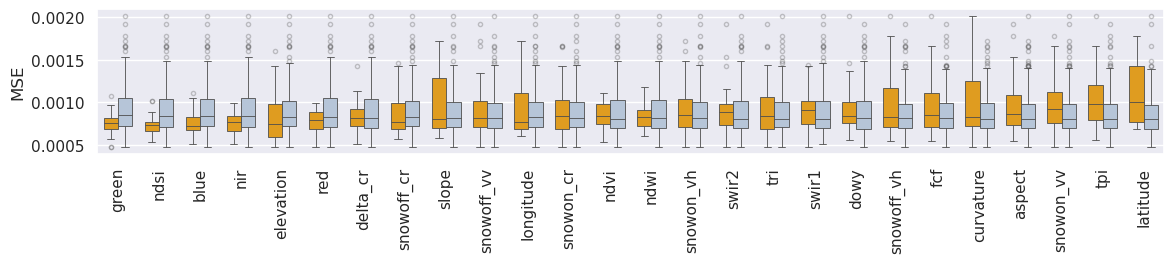

In [108]:
sns.set_theme()

# Melt the DataFrame
df_melted = pd.melt(df, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric', value_name='value')

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2.8))

# Bottom plot: Performance metrics 3 and 4
sns.boxplot(x='channel', y='value', hue='metric', order=sorted_columns, data=df_melted, ax=ax,
           flierprops={"marker": "o", "alpha": 0.3}, fliersize=3, legend=False, palette=palette,
           linewidth=0.6, width=0.7)
#ax.set_title('validation performance with and without channel')
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()


# Save the plot
plt.savefig('../../figs/monte_carlo_MSE.png', dpi=300, bbox_inches="tight")

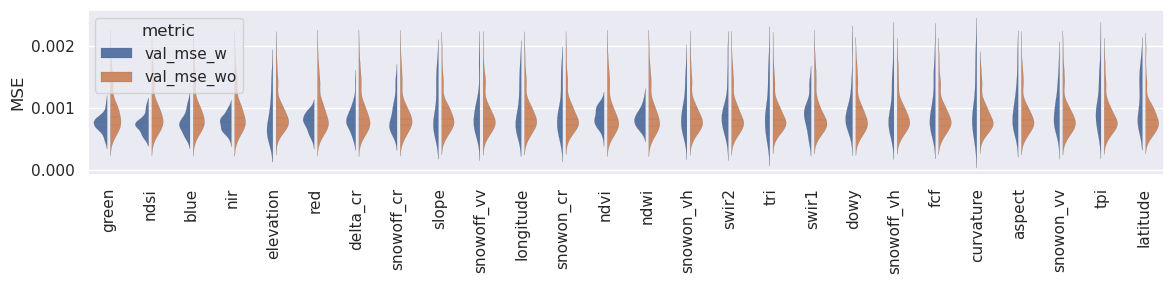

In [59]:
# Melt the DataFrame
df_melted = pd.melt(df, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric', value_name='value')

sns.set_theme()

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

# Violin plot with split
sns.violinplot(x='channel', y='value', hue='metric', inner='quart', linewidth=0.1, gap=0.2, data=df_melted, order=sorted_columns, split=True, ax=ax)
#ax.set_title('Validation Performance with and without Channel')
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()

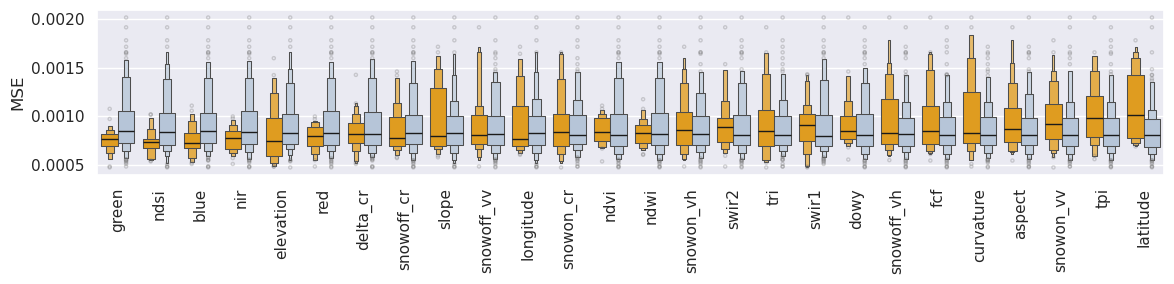

In [107]:
# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

# Custom colors for each metric
palette = {'val_mse_w': 'orange', 'val_mse_wo': 'lightsteelblue'}

# Swarm plot
sns.boxenplot(x='channel', y='value', hue='metric', data=df_melted, order=sorted_columns,
              ax=ax, k_depth='proportion', outlier_prop=0.2, flier_kws={"marker": "o", 's':5, "alpha": 0.3},
              line_kws=dict(linewidth=1, color="k"), legend=False, palette=palette)
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()
plt.show()

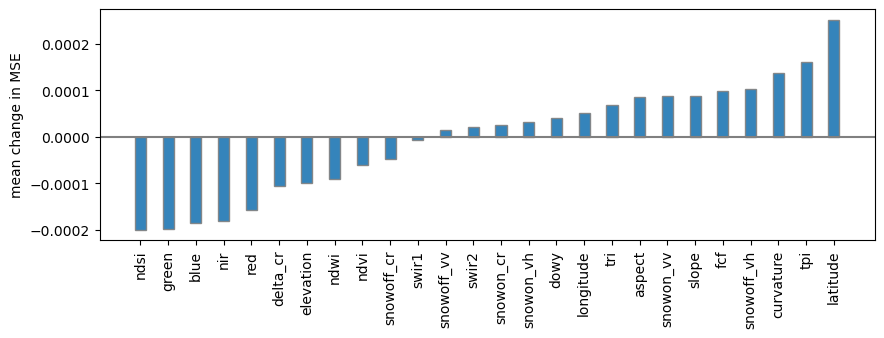

In [13]:
# Set the position of the bars on the x-axis
bar_width = 0.4
r1 = np.arange(len(df_summary['channels']))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(r1, df_summary['val_loss_diff'], width=bar_width, edgecolor='grey', alpha=0.9)
# Add labels
ax.set_xlabel('')
ax.set_xticks([r for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('mean change in MSE')
ax.axhline(0, c='grey')
#ax.set_title('mean change in validation MSE when channels are included')
plt.savefig('../../figs/monte_carlo_MSE_change.png', dpi=300)

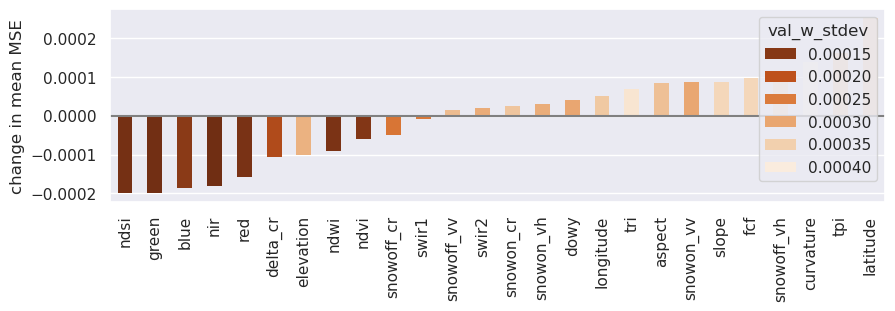

In [9]:
sns.set_theme()
# Create the plot
fig, ax = plt.subplots(figsize=(10, 2.5))
sns.barplot(x='channels', y='val_loss_diff', hue='val_w_stdev', palette='Oranges_r', data=df_summary, linewidth=0, legend=True, width=0.5)

# Add labels
ax.set_xlabel('')
ax.set_xticks([r for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('change in mean MSE')
ax.axhline(0, c='grey')
# ax.set_title('mean change in validation MSE when channels are included')

# Save the plot
plt.savefig('../../figs/monte_carlo_MSE_change.png', dpi=300, bbox_inches="tight")

ValueError: The following variable cannot be assigned with wide-form data: `hue`

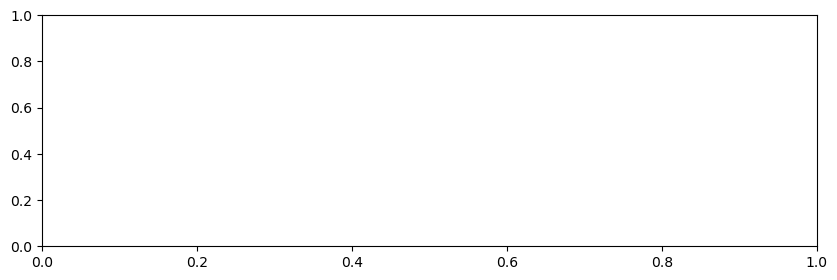

In [15]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(df_summary['val_loss_diff'], hue=df_summary['val_w_stdev'])
# Add labels
ax.set_xlabel('')
ax.set_xticks([r for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('mean change in MSE')
ax.axhline(0, c='grey')
#ax.set_title('mean change in validation MSE when channels are included')
plt.savefig('../../figs/monte_carlo_MSE_change.png', dpi=300)

In [9]:
experiment_data

{1: [['latitude', 'swir1', 'tri', 'fcf', 'snowoff_vh'], 0.000991828343103407],
 2: [['fcf', 'snowoff_cr', 'nir', 'snowon_vv', 'delta_cr'],
  0.0007330565008487611],
 3: [['longitude', 'swir2', 'tpi', 'latitude', 'snowoff_cr'],
  0.0014202314978319919],
 4: [['snowon_cr', 'latitude', 'tri', 'snowon_vv', 'slope'],
  0.0016568277023907285],
 5: [['nir', 'fcf', 'delta_cr', 'ndwi', 'dowy'], 0.0008479191574224387],
 6: [['elevation', 'tpi', 'blue', 'slope', 'snowoff_vh'],
  0.000596755669448612],
 7: [['ndsi', 'aspect', 'snowon_vv', 'snowoff_vv', 'snowon_vh'],
  0.0007644925924523704],
 8: [['green', 'dowy', 'nir', 'snowoff_vh', 'ndwi'], 0.0008452602135093912],
 9: [['tri', 'ndwi', 'elevation', 'snowon_cr', 'snowoff_vh'],
  0.000953883179136028],
 10: [['green', 'aspect', 'slope', 'dowy', 'blue'], 0.0007248822153087531],
 11: [['ndvi', 'snowoff_vv', 'snowoff_vh', 'dowy', 'longitude'],
  0.0010103217191499425],
 12: [['snowoff_cr', 'green', 'slope', 'swir1', 'tpi'], 0.0007038467415441119],
 1